In [1]:
import sys
 
sys.path.insert(0, "../")

from EnsembleFramework import Framework

In [2]:
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.utils import add_self_loops

dataset_name = 'Cora'
split = "public"
dataset = Planetoid(root='/tmp/Cora', name=dataset_name, split=split)
dataset.transform = T.NormalizeFeatures()

features =  dataset[0].x
y =  dataset[0].y

test =  dataset[0].test_mask
train = dataset[0].train_mask
val =  dataset[0].val_mask

edge_index = dataset[0].edge_index 
edge_index = add_self_loops(edge_index)[0]

In [8]:
import torch
from torch.nn.functional import normalize
def user_function(kwargs):
    return normalize(kwargs["original_features"] + kwargs["summed_neighbors"], p=2, dim =1)


hops_list = [0, 2,3,4,5,6,7,8,9,10,15]
framework = Framework([user_function for i in hops_list], 
                     hops_list=hops_list, ## to obtain best for local neighborhood
                     clfs=[],
                     gpu_idx=0,
                     handle_nan=0.0,
                    attention_configs=[{'inter_layer_normalize': True,
                     'use_pseudo_attention':True,
                     'cosine_eps':.01,
                     'dropout_attn': None} for i in hops_list])
{'inter_layer_normalize': True,
                     'use_pseudo_attention':True,
                     'cosine_eps':.01,
                     'dropout_attn': None}
new_features = framework.get_features(features, edge_index,torch.ones_like(y).type(torch.bool))#train

/home/dwalke/git/graph_aware_ml/EnsembleFramework.py:146: UserWarning: The reduce argument of torch.scatter with Tensor src is deprecated and will be removed in a future PyTorch release. Use torch.scatter_reduce instead for more reduction options. (Triggered internally at ../aten/src/ATen/native/TensorAdvancedIndexing.cpp:230.)
  summed_exp_score = torch.zeros_like(exp_score).scatter(0, target,exp_score, reduce="add")


In [9]:
new_features[0].shape

torch.Size([2708, 1433])

In [11]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score

scores = []
eu_scores = []
sparsities = []
for i, hop_features in enumerate(new_features):
    print(f"Hop {hops_list[i]}")
    sparsity = round(((hop_features == 0).sum()*100 / hop_features.numel()).item(), 2)
    sparsities.append(sparsity)
    print(f"Sparsity {sparsity} %")
    score = silhouette_score(hop_features.cpu(), y, metric="cosine")
    eu_score = silhouette_score(hop_features.cpu(), y)
    scores.append(score)
    eu_scores.append(eu_score)

Hop 0
Sparsity 98.73 %
Hop 2
Sparsity 86.16 %
Hop 3
Sparsity 67.93 %
Hop 4
Sparsity 46.08 %
Hop 5
Sparsity 28.2 %
Hop 6
Sparsity 17.65 %
Hop 7
Sparsity 12.76 %
Hop 8
Sparsity 10.64 %
Hop 9
Sparsity 9.62 %
Hop 10
Sparsity 9.17 %
Hop 15
Sparsity 8.89 %


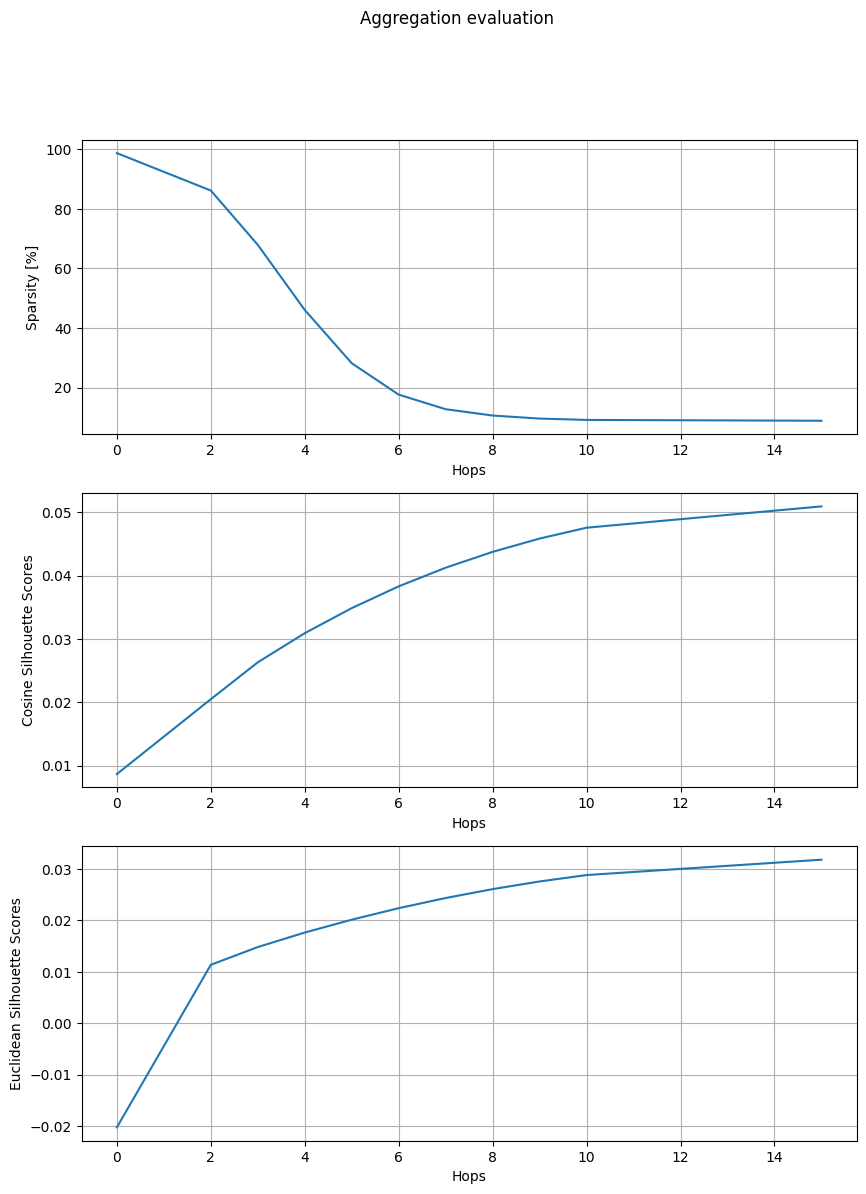

In [12]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
fig.set_figheight(13)
fig.set_figwidth(10)
fig.suptitle('Aggregation evaluation')

ax1.plot(hops_list, sparsities)
ax1.set_xlabel("Hops")
ax1.set_ylabel("Sparsity [%]")
ax1.grid()

ax2.plot(hops_list, scores)
ax2.set_xlabel("Hops")
ax2.set_ylabel("Cosine Silhouette Scores")
ax2.grid()

ax3.plot(hops_list, eu_scores)
ax3.set_xlabel("Hops")
ax3.set_ylabel("Euclidean Silhouette Scores")
ax3.grid()

In [13]:
from torch.nn.functional import cosine_similarity
a = torch.tensor([[-1,0]], dtype=torch.float)
b = torch.tensor([[1, 0]], dtype=torch.float)
cosine_similarity(a,b)

tensor([-1.])